# Análise de risco em transações - Conhecendo os dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
%matplotlib inline

In [2]:
transactions = pd.read_csv('transactions.csv')

In [3]:
transactions.shape

(3199, 8)

Verificação inicial, temos 3199 vendas nesse dataframe.


In [4]:
transactions.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


In [5]:
comerciantes = transactions.merchant_id.unique()
comerciantes.shape

(1756,)

Essas 3199 vendas foram realizadas por 1756 comerciantes.


In [6]:
chargebacks = transactions.loc[transactions.has_cbk == True]
chargebacks.shape

(391, 8)

Das 3199 vendas, temos 391 chargebacks, mais de 12%


In [7]:
comerciantes_com_chargeback = chargebacks.merchant_id.unique()
comerciantes_com_chargeback.shape

(118,)

Os 391 chargebacks foram realizados por 118 comerciantes.


In [8]:
vendas_por_comerciante = transactions.loc[:, ['merchant_id','transaction_id']].groupby('merchant_id').count().sort_values('transaction_id', ascending = False)
vendas_por_comerciante.describe()
vendas_por_comerciante

,transaction_id
merchant_id,
49205,73
17275,30
4705,22
79698,22
53041,19
...,...
37593,1
37432,1
37339,1


na descrição de vendas por comerciante, podemos ver pelos quartis que grande parte deles só realizou uma venda, essa é uma informação importante 
pra reforçar a necessidade de ter uma amostra maior ao considerar as classificações de risco


<AxesSubplot:ylabel='Count'>

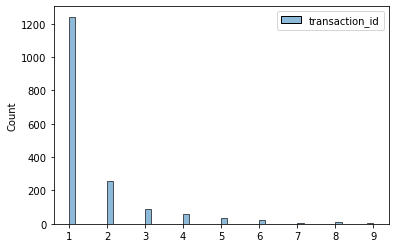

In [9]:
sb.histplot(vendas_por_comerciante.loc[vendas_por_comerciante.transaction_id.astype('int') < 10])

De forma gráfica


# Verificando a porcentagem de ChargeBacks por lojista 

Uma forma pertinente de classificação de risco é verificar a proporção de chargebacks por venda para cada lojista, a partir desses dados podemos montar um modelo que faça a classificação de risco.

In [10]:
# Organizando um dataframe que mostre a quantidade de vendas e ChargeBacks por comerciantes que já tiveram algum.
pct_cb = transactions.loc[:,['merchant_id', 'transaction_id','has_cbk']][transactions['merchant_id'].isin(comerciantes_com_chargeback)]
pct_cb.transaction_id = 1
pct_cb = pct_cb.groupby('merchant_id').sum()
# Renomeando as colunas
pct_cb.rename(columns={'transaction_id': 'vendas', 'has_cbk': 'chargebacks'}, inplace = True)
# Adicionando uma coluna com porcentagem
pct_cb['porcentagem'] = pct_cb.chargebacks / pct_cb.vendas * 100
# Ordenando o dataframe por porcentagem e número de chargebacks
pct_cb = pct_cb.sort_values(by = ['porcentagem', 'chargebacks'], ascending = False)

In [11]:
pct_cb

,vendas,chargebacks,porcentagem
merchant_id,,,
1308,15,15,100.000000
44927,11,11,100.000000
73271,10,10,100.000000
38337,6,6,100.000000
48126,6,6,100.000000
...,...,...,...
38901,4,1,25.000000
68953,6,1,16.666667
90035,7,1,14.285714


<AxesSubplot:xlabel='porcentagem', ylabel='Count'>

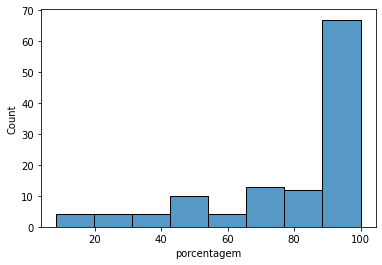

In [12]:
sb.histplot(pct_cb.porcentagem)

<br><br>Descobrindo qual a porcentagem de lojistas que tiveram chargeback em 100% das suas vendas:


In [13]:
pct_cb.porcentagem.loc[pct_cb.porcentagem == 100].count() / pct_cb.porcentagem.count() * 100

55.932203389830505

Analisando a tabela e o gráfico, podemos verificar que 56% dos comerciantes que já tiveram algum chargeback, o tiveram em 100% das suas vendas. 

Com o já explorado até aqui, podemos partir para a elaboração de um modelo de classificação de risco.

# Modelo de classificação de risco

Regras do modelo:<br>
<br>
Comerciantes com 100% das vendas à primeira vista têm alta possibilidade de estarem envolvidos em algum tipo de fraude, porém um fator que não podemos deixar de considerar é o tamanho da amostra, por exemplo, comerciantes que tiveram apenas uma venda e um chargeback não podem ter o mesmo grau de risco que comerciantes que tiveram quinze vendas e quinze chargebacks.<br>
- Caso o comerciante tenha 100% de suas vendas acometidas de chargeback:<br>
  - 2 ou menos vendas - baixo risco (1)<br>
  - 3 a 5 vendas - médio risco (2) <br>
  - 6 ou mais vendas - alto risco (3)<br> 
  
A sabedoria dos antigos diz que 'para uma mentira ser boa, esta deve estar floreada com um pouco de verdade', os bons fraudadores entendem isso bem, então muitos deles vão realizar algumas transações legítimas para não serem identificados tão facilmente. Assim sendo, será comum nos depararmos com fraudadores que não tenham 100% de compras com Chargeback. <br>
Como a porcentagem de chargebacks sobre as compras diminuiu, aumentaremos em 1 o número de compras necessárias para progressão de zona de risco em relação a comerciantes com 100% de chargeback

 -  Caso o comerciante tenha de 50% a 99% de suas vendas acometidas de chargeback:<br>
    - 3 ou menos vendas - baixo risco (1)<br>
    - 4 a 6 vendas - médio risco (2)<br>
    - 7 ou mais vendas - alto risco (3)<br><br>
 
 - Caso o comerciante tenha menos de 50% das vendas acometidas de chargeback, podemos considerá-lo baixo risco (1).
 - Se o comerciante não tiver histórico de chargeback, o consideraremos o risco nulo (0).
  
 

In [14]:
def risk_setter(dataframe):
    """função que define o risco de um comerciante a partir da porcentagem de vendas que tiveram chargeback
    - necessário usar como parâmetro um dataframe com as colunas merchant_id, transaction_id e has_cbk"""
    
    # Criando as colunas necessárias para o cálculo de porcentagem de chargebacks sobre venda no Dataframe
    
    dataframe_copy = dataframe.loc[:,['merchant_id', 'transaction_id', 'has_cbk']] 
    dataframe_copy.transaction_id = 1 
    dataframe_copy = dataframe_copy.groupby('merchant_id').sum() 
    dataframe_copy.rename(columns={'transaction_id':'merchant_sails_count', 'has_cbk':'merchant_cb_count'}, inplace = True) 
    dataframe_copy['cb_pct'] = dataframe_copy.merchant_cb_count / dataframe_copy.merchant_sails_count * 100
    dataframe_copy['cb_pct'] = round(dataframe_copy['cb_pct'], 2)
    dataframe = dataframe.join(dataframe_copy, on='merchant_id')
    warnings.filterwarnings('ignore', '.*', )
    
    # Fazendo as checagens e definindo o risco
    
    dataframe['merchant_risk'] = 'null'
    dataframe['risk_level'] = 0
    
    for line in range(len(dataframe)):
                
        if dataframe.cb_pct[line] == 100:           
            if dataframe.merchant_sails_count[line] <= 2:
                dataframe.merchant_risk[line] = 'low'
                dataframe.risk_level[line] = 1                
            elif 3 <= dataframe.merchant_sails_count[line] <= 5:
                dataframe.merchant_risk[line] = 'medium'
                dataframe.risk_level[line] = 2               
            else:
                dataframe.merchant_risk[line] = 'high'
                dataframe.risk_level[line] = 3
                                
        elif 50 <= dataframe.cb_pct[line] < 100:           
            if dataframe.merchant_sails_count[line] <= 3:
                dataframe.merchant_risk[line] = 'low'
                dataframe.risk_level[line] = 1               
            elif 4 <= dataframe.merchant_sails_count[line] <= 6:
                dataframe.merchant_risk[line] = 'medium'
                dataframe.risk_level[line] = 2              
            else:
                dataframe.merchant_risk[line] = 'high'
                dataframe.risk_level[line] = 3
                               
        elif 0 < dataframe.cb_pct[line] < 50:
            dataframe.merchant_risk[line] = 'low'
            dataframe.risk_level[line] = 1
       
    return dataframe

transactions = risk_setter(transactions)
transactions

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,merchant_sails_count,merchant_cb_count,cb_pct,merchant_risk,risk_level
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False,11,1,9.09,low,1
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True,2,1,50.00,low,1
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False,3,0,0.00,null,0
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True,1,1,100.00,low,1
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False,1,0,0.00,null,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,21323592,50493,49581,650486******4139,2019-11-01T13:05:34.054967,744.15,NaN,False,4,0,0.00,null,0
3195,21323593,9603,59275,528052******3611,2019-11-01T11:47:02.404963,1403.67,NaN,False,1,0,0.00,null,0
3196,21323594,57997,84486,522688******9874,2019-11-01T10:23:50.555604,1.55,NaN,False,3,0,0.00,null,0
3197,21323595,35930,7,544315******7773,2019-11-01T01:29:45.799767,359.68,NaN,False,3,0,0.00,null,0


Criando uma planilha modificada, pra garantir que o modelo funciona com diferentes planilhas:

In [15]:
modificada = pd.read_csv('modificada.csv')
modificada = risk_setter(modificada)
modificada

,transaction_id,merchant_id,has_cbk,merchant_sails_count,merchant_cb_count,cb_pct,merchant_risk,risk_level
0,21320398,29744,True,11,11,100.0,high,3
1,21320399,92895,True,2,2,100.0,low,1
2,21320400,47759,True,3,3,100.0,medium,2
3,21320401,68657,True,1,1,100.0,low,1
4,21320402,54075,True,1,1,100.0,low,1
...,...,...,...,...,...,...,...,...
3194,21323592,50493,False,4,0,0.0,null,0
3195,21323593,9603,False,1,0,0.0,null,0
3196,21323594,57997,False,3,0,0.0,null,0
3197,21323595,35930,False,3,0,0.0,null,0
